# 課題２ 物件価格予測回帰問題

## データセット作成
- データの前処理、データセットの作成方法について説明してください。
- 学習データ、バリデーションデータ、テストデータの分け方や説明変数、目的変数の作成方法等について詳細を説明してください。
    - 説明変数、目的変数の作り方が重要なポイントとなります。

## モデル構築
- どのようなモデルを選んだか、どのようなアーキテクチャにしたのか、理由を含めて説明して下さい。
- モデル学習時のハイパーパラメーター等、学習方法について理由を含めて説明して下さい。

## テスト結果
- テストデータにおける各サンプルに対して予測値（回帰結果）を付与した後、平均絶対誤差（MAE：Mean Absolute Error）、二乗平均平方根誤差（RMSE：Root Mean Squared Error）、R2スコアをそれぞれ計算して記入して下さい。
- Kaggleで同様の課題に取り組まれた場合は、Team NameとLeaderboardにおける順位（#）を記入して下さい。

In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import seaborn as sb
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, KFold,GridSearchCV
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.preprocessing import StandardScaler,RobustScaler,LabelEncoder,PowerTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
#StackingRegressor
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import seaborn as sns

In [251]:
train_data = pd.read_csv("../input/Price.csv")

In [252]:
pd.get_option("display.max_columns")
pd.set_option('display.max_columns', 50)

train_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [46]:
train_data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

### 変数説明
id-住宅販売

date-住宅販売

price - 各住宅販売の

bedroms - 寝室の数

bathrooms - バスルームの数

bathrooms - .5はトイレはあるがシャワーはない部屋の場合

sqft_living-平方フィートマンションインテリア生活空間の

sqft_lot - 土地空間の広場映像

floors -床の数

waterfront -アパートウォーターフロントを見下ろすされたか否かについてダミー変数

view -インデックス0から4までどのように良いのプロパティの表示状態でした

condition -マンションの状態に関する1から5までのインデックス、

grade  -1から13までのインデックス。1〜3は建物の建設と設計に達していない、7は平均レベルの建設と設計、11〜13は高品質の構造とデザイン。

sqft_above -グランドレベルより上にあるハウジング内部空間の平方フィート

sqft_basementグラウンドレベルを下回っている内部収納空間の平方フィート-

yr_built家が最初に建てられた年-

yr_renovated -家の最後の改装の年

zipcode  -郵便番号は何面積家はある

lat - Lattitude

long -経度

sqft_living15-最寄りの15人の近隣の住居の居住空間の平方フィート

sqft_lot15-最寄りの15人の近隣の土地区画の平方フィート

In [41]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,21613.0,4.580302e+09,2.876566e+09,1.000102e+06,2.123049e+09,3.904930e+09,7.308900e+09,9.900000e+09
price,21613.0,5.400881e+05,3.671272e+05,7.500000e+04,3.219500e+05,4.500000e+05,6.450000e+05,7.700000e+06
bedrooms,21613.0,3.370842e+00,9.300618e-01,0.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.300000e+01
bathrooms,21613.0,2.114757e+00,7.701632e-01,0.000000e+00,1.750000e+00,2.250000e+00,2.500000e+00,8.000000e+00
sqft_living,21613.0,2.079900e+03,9.184409e+02,2.900000e+02,1.427000e+03,1.910000e+03,2.550000e+03,1.354000e+04
sqft_lot,21613.0,1.510697e+04,4.142051e+04,5.200000e+02,5.040000e+03,7.618000e+03,1.068800e+04,1.651359e+06
floors,21613.0,1.494309e+00,5.399889e-01,1.000000e+00,1.000000e+00,1.500000e+00,2.000000e+00,3.500000e+00
waterfront,21613.0,7.541757e-03,8.651720e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
view,21613.0,2.343034e-01,7.663176e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
condition,21613.0,3.409430e+00,6.507430e-01,1.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00


In [55]:
y_data = pd.DataFrame({"price":train_data["price"], "log(price+1)":np.log1p(train_data["price"])})

## 目的変数の分析

目的変数：Price

- 目的変数の構造把握

In [12]:
# 記述統計の要約
y_data.iloc[:,0].describe()

count    2.161300e+04
mean     5.400881e+05
std      3.671272e+05
min      7.500000e+04
25%      3.219500e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

最低価格が0以上となっているので，削除する必要がある説明変数は存在しない

- 目的変数の分布確認

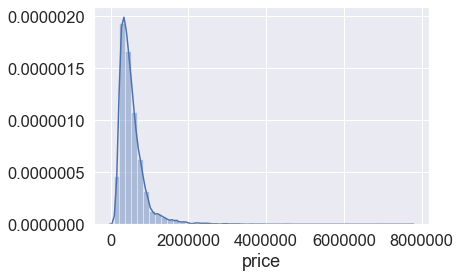

In [18]:
sns.distplot(y_data.iloc[:,0])

- 正規分布からかなり遠い形をしている
- 正の歪度が強い傾向がある

In [209]:
print("Skewness: %f" % y_data['price'].skew())
print("Kurtosis: %f" % y_data['price'].kurt())

Skewness: 4.024069
Kurtosis: 34.585540


- 目的変数に対数を取ったときの傾向

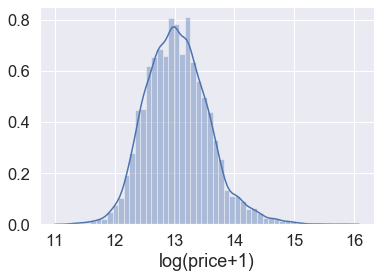

In [210]:
sns.distplot(y_data.iloc[:,1])

## 説明変数分析


### 欠損値確認


In [211]:
train_data.isnull().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
sales_yr         0
house_age        0
age_rnv          0
dtype: int64

欠損値なし

### 特徴量作成
- sales_yr: 

販売年代

- house_age

築年数

- age_rnv

リノベーション年数

In [253]:
train_data['sales_yr']=train_data['date'].astype(str).str[:4]

train_data['house_age']=train_data['sales_yr'].astype(int)-x_data['yr_built']

train_data['age_rnv']=0
train_data['age_rnv']=train_data['sales_yr'][train_data['yr_renovated']!=0].astype(int)-train_data['yr_renovated'][train_data['yr_renovated']!=0]
train_data['age_rnv'][train_data['age_rnv'].isnull()]=0

C:\Users\hirakata\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [217]:
test["count"] = train_data.groupby("zipcode").count()["price"]

check = pd.DataFrame(test.index)
check = pd.concat([check, pd.DataFrame(test.values)],axis=1)
check.columns = ["zipcode","zipcode_cnt"]

train_data = pd.merge(train_data,check, on="zipcode")

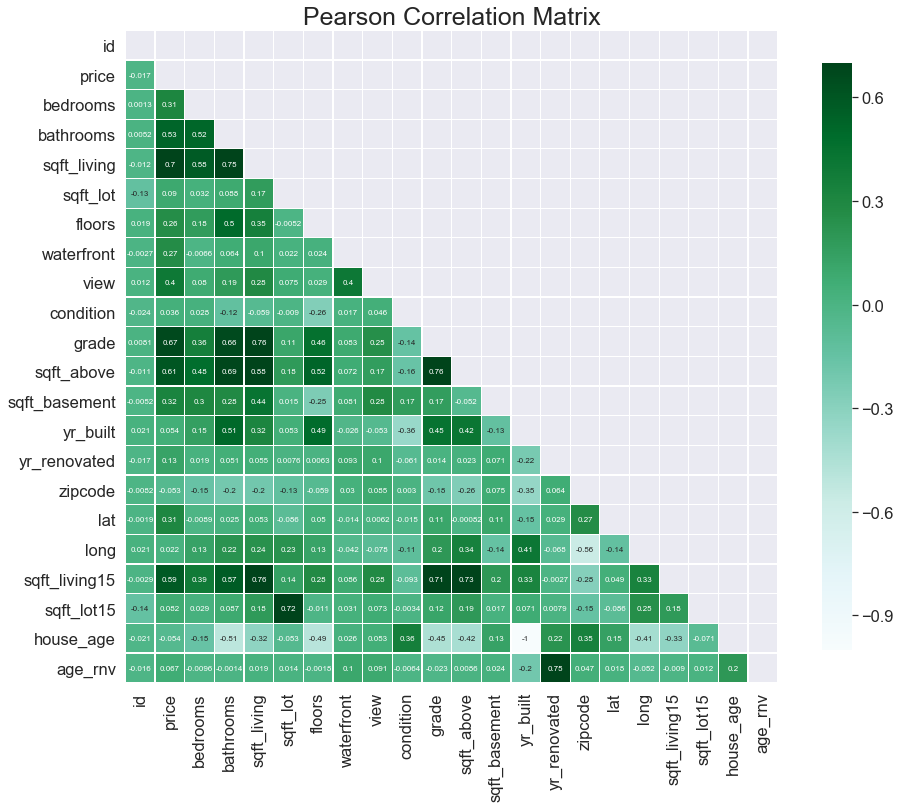

In [254]:
features = list(train_data.columns)


mask = np.zeros_like(train_data[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(train_data[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

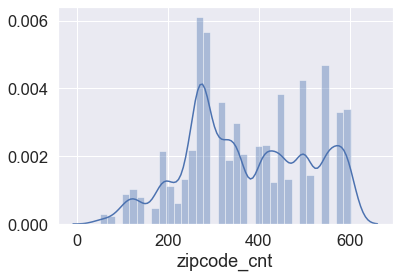

In [220]:
sns.distplot(train_data["zipcode_cnt"])

In [255]:
# id, date列を削除
train_data = train_data.drop(["date"],axis=1)
train_data = train_data.drop(["id"],axis=1)

In [256]:
x_data = train_data.drop(["price"],axis=1)

### 正則化

In [257]:
std_scaler=StandardScaler()
rbst_scaler=RobustScaler()
power_transformer=PowerTransformer()
X_std=std_scaler.fit_transform(x_data)
X_rbst=rbst_scaler.fit_transform(x_data)
X_pwr=power_transformer.fit_transform(x_data)

C:\Users\hirakata\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:2863: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\hirakata\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:2828: RuntimeWarning: overflow encountered in power
  out[pos] = (np.power(x[pos] + 1, lmbda) - 1) / lmbda
C:\Users\hirakata\Anaconda3\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\hirakata\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:2832: RuntimeWarning: overflow encountered in power
  out[~pos] = -(np.power(-x[~pos] + 1, 2 - lmbda) - 1) / (2 - lmbda)
C:\Users\hirakata\Anaconda3\lib\site-packages\numpy\core\_methods.py:122: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


## モデル作成

In [258]:
Y = y_data["log(price+1)"]

In [227]:
def overfit_reducer(df):

    overfit = []
    for i in df.columns:
        counts = df[i].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df) * 100 > 99.9:
            overfit.append(i)
    overfit = list(overfit)
    return overfit
overfitted_features = overfit_reducer(x_data)

In [228]:
print(x_data.shape)

(21613, 22)


### メモ
-  データの分け方を考える必要がある
- 学習データ、バリデーションデータ、テストデータ

学習データとテストデータの分け方
バリデーションデータを用いずに、トレーニンデータのみからクロスバリデーションによりハイパーパラメータを選ぶ方法もあります。わたしは、ほとんどの場合において、クロスバリデーションでハイパーパラメータを選んでいます。
https://datachemeng.com/doublecrossvalidation/

In [259]:
x_train,x_test,y_train,y_test=train_test_split(X_std,Y,test_size=0.2,random_state=52)

print('X_train Shape :',x_train.shape)
print('X_test Shape :',x_test.shape)
print('y_train Shape :',y_train.shape)
print('y_test Shape :',y_test.shape)

X_train Shape : (17290, 21)
X_test Shape : (4323, 21)
y_train Shape : (17290,)
y_test Shape : (4323,)


### 学習

片っ端からモデルを試してみる
**アンサンブル学習もあり**

---評価指標---
- $R^2$ (決定係数)

$R^2$ (決定係数)は以下の式で計算され、出力の実測値 $y_{obs}$ と出力の予測値 $y_{pred}$ の間の相関係数を表す．

$R^2$ は $y_{obs}$ と $y_{pred}$ が完全に一致する場合に 1 となり、1 に近いほど精度の高い予測が行えていることを表す．

- Root Mean Squared Error (RMSE)

RMSE は、後述する MAE と共に平均化された誤差の値を表す．

RMSE が 0 に近いほど見積もられる予測誤差が小さい、すなわち予測精度が高いことを表す．

- Mean Absolute Error (MAE)

MAE は以下の式で計算され、RMSE と共に平均化された誤差の大きさを表す．

In [308]:
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression

dataset = datasets.load_breast_cancer()
X, y = dataset.data, dataset.target

clf = LinerRegression()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

score_funcs = {
    #'builtin_accuracy': 'accuracy',
    # オリジナルの評価関数を登録する
    #'custom_accuracy': make_scorer(accuracy_score),  # make_scorer() でラップする
    "mean_absolute_error": make_scorer(mean_absolute_error),
    "r2_score": make_scorer(r2_score),
    "mean_squared_error": make_scorer(mean_squared_error)
}

scores = cross_validate(clf, X, y, cv=skf, scoring=score_funcs)

print('r2 score:', scores['test_r2_score'].mean())
print('mean absolute error:', scores['test_mean_absolute_error'].mean())
print('mean squared error:', scores['test_mean_squared_error'].mean())

r2 score: 0.8365047513125766
mean absolute error: 0.08331961242630949
mean squared error: 0.038215250141971545


In [338]:
# 交差検証 設定
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

#skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf = KFold(n_splits=5, shuffle=True, random_state=42)

score_funcs = {
    #'builtin_accuracy': 'accuracy',
    # オリジナルの評価関数を登録する
    #'custom_accuracy': make_scorer(accuracy_score),  # make_scorer() でラップする
    "mean_absolute_error": make_scorer(mean_absolute_error),
    "r2_score": make_scorer(r2_score),
    "mean_squared_error": make_scorer(mean_squared_error)
}

#scores = cross_validate(clf, X, y, cv=skf, scoring=score_funcs)

#print('r2 score:', scores['test_r2_score'].mean())
#print('mean absolute error:', scores['test_mean_absolute_error'].mean())
#print('mean squared error:', scores['test_mean_squared_error'].mean())

In [340]:
lgb_regressor=lgb.LGBMRegressor(objective='regression', num_leaves=5, learning_rate=0.035, n_estimators=2177, max_bin=50, bagging_fraction=0.65,bagging_freq=5, bagging_seed=7, 
                                feature_fraction=0.201, feature_fraction_seed=7,n_jobs=-1)
scores = cross_validate(lgb_regressor, X_std, Y, cv=skf, scoring=score_funcs)

print('-'*10+'LGBM'+'-'*10)
print('r2 score:', scores['test_r2_score'].mean())
print('mean absolute error:', scores['test_mean_absolute_error'].mean())
print('mean squared error:', scores['test_mean_squared_error'].mean())

----------LGBM----------
r2 score: 0.8996512709134089
mean absolute error: 0.12028740887346293
mean squared error: 0.027824884459342704


In [341]:
gb_reg = GradientBoostingRegressor(n_estimators=1992, learning_rate=0.03005, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=14, loss='huber', random_state =42)
scores = cross_validate(gb_reg, X_std, Y, cv=skf, scoring=score_funcs)

print('-'*10+'GBR'+'-'*10)
print('r2 score:', scores['test_r2_score'].mean())
print('mean absolute error:', scores['test_mean_absolute_error'].mean())
print('mean squared error:', scores['test_mean_squared_error'].mean())

----------GBR----------
r2 score: 0.9083195253632603
mean absolute error: 0.11235119931926105
mean squared error: 0.025417436008330702


In [342]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

alphas=[1e-9,1e-8,1e-7,1e-6]

ridgecv_reg= make_pipeline(RidgeCV(alphas=alphas, cv=kfolds))
scores = cross_validate(ridgecv_reg, X_std, Y, cv=skf, scoring=score_funcs)

#ridgecv_reg.fit(x_train, y_train)
#y_head=ridgecv_reg.predict(x_test)
print('-'*10+'RidgeCV'+'-'*10)
print('r2 score:', scores['test_r2_score'].mean())
print('mean absolute error:', scores['test_mean_absolute_error'].mean())
print('mean squared error:', scores['test_mean_squared_error'].mean())

----------RidgeCV----------
r2 score: 0.7725288512084825
mean absolute error: 0.19471033794587916
mean squared error: 0.06307918314872732


In [157]:
pd.DataFrame({"ans":np.floor(np.expm1(y_test)), "test":np.floor(np.expm1(y_head))}).head()

,ans,test
2005,276900.0,342295.0
17841,159100.0,223261.0
17859,430000.0,753625.0
814,2400000.0,1650036.0
2632,249999.0,235697.0


In [343]:
kfolds = KFold(n_splits=8, shuffle=True, random_state=42)

lassocv_reg= make_pipeline(LassoCV(alphas=alphas, cv=kfolds))
scores = cross_validate(lassocv_reg, X_std, Y, cv=skf, scoring=score_funcs)

#lassocv_reg.fit(x_train, y_train)
#y_head=lassocv_reg.predict(x_test)
print('-'*10+'LassoCV'+'-'*10)
print('R square Accuracy: ',r2_score(y_test,y_head))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_head))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_head))

C:\Users\hirakata\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79.87961847647466, tolerance: 0.4168056524408049
  tol, rng, random, positive)
C:\Users\hirakata\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79.86060114922714, tolerance: 0.4168056524408049
  tol, rng, random, positive)
C:\Users\hirakata\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79.85869816961372, tolerance: 0.4168056524408049
  tol, rng, random, positive)
C:\Users\hirakata\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converg

C:\Users\hirakata\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89.45086699664205, tolerance: 0.47622721460279527
  positive)
C:\Users\hirakata\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81.46714079317815, tolerance: 0.41660513526430243
  tol, rng, random, positive)
C:\Users\hirakata\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81.44800715425868, tolerance: 0.41660513526430243
  tol, rng, random, positive)
C:\Users\hirakata\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wa

C:\Users\hirakata\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93.19721522653833, tolerance: 0.4785313838843393
  positive)
C:\Users\hirakata\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79.92246738750475, tolerance: 0.42351184481927134
  tol, rng, random, positive)
C:\Users\hirakata\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79.90306758971929, tolerance: 0.42351184481927134
  tol, rng, random, positive)
C:\Users\hirakata\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wan

C:\Users\hirakata\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91.99454815099921, tolerance: 0.4833074295445825
  positive)
C:\Users\hirakata\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82.45119523056565, tolerance: 0.4209204833566459
  tol, rng, random, positive)
C:\Users\hirakata\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82.43198854971456, tolerance: 0.4209204833566459
  tol, rng, random, positive)
C:\Users\hirakata\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want 

C:\Users\hirakata\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93.23864902835817, tolerance: 0.4800251586271785
  positive)
C:\Users\hirakata\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81.32546431839341, tolerance: 0.42087042873923086
  tol, rng, random, positive)
C:\Users\hirakata\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81.30636843785567, tolerance: 0.42087042873923086
  tol, rng, random, positive)
C:\Users\hirakata\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wan

----------LassoCV----------
R square Accuracy:  0.9100038030225648
Mean Absolute Error Accuracy:  0.1128248922720093
Mean Squared Error Accuracy:  0.025305677200883732


C:\Users\hirakata\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92.16790319032634, tolerance: 0.4799200614491446
  positive)


In [344]:
kfolds = KFold(n_splits=8, shuffle=True, random_state=42)

alphas=[0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006]
l1ratio=[0.87, 0.9,0.92, 0.95,0.97, 0.99, 1]

elasticv_reg= make_pipeline(ElasticNetCV(alphas=alphas, cv=kfolds, l1_ratio=l1ratio))
scores = cross_validate(elasticv_reg, X_std, Y, cv=skf, scoring=score_funcs)

print('-'*10+'ElasticNetCV'+'-'*10)
print('R square Accuracy: ',r2_score(y_test,y_head))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_head))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_head))

----------ElasticNetCV----------
R square Accuracy:  0.9100038030225648
Mean Absolute Error Accuracy:  0.1128248922720093
Mean Squared Error Accuracy:  0.025305677200883732


In [163]:
pd.DataFrame({"ans":np.floor(np.expm1(y_test)), "test":np.floor(np.expm1(y_head))}).head()

,ans,test
2005,276900.0,342404.0
17841,159100.0,223357.0
17859,430000.0,753425.0
814,2400000.0,1648779.0
2632,249999.0,235692.0
